In [1]:
import pandas as pd
import matplotlib.pyplot as plt
import seaborn as sns
import plotly.express as px
import numpy as np
import warnings
warnings.filterwarnings('ignore')

# Install required packages for geographic analysis
try:
    import geopandas
    import pycountry
except ImportError:
    print("Installing geopandas and pycountry...")
    import subprocess
    subprocess.run(["pip", "install", "geopandas", "pycountry"])
    import geopandas
    import pycountry

# Set global plotting configuration
plt.rcParams['figure.figsize'] = (12, 8)
sns.set_style("whitegrid")

print("=" * 60)
print("COMPREHENSIVE HORIZON EUROPE DATA ANALYSIS")
print("=" * 60)


COMPREHENSIVE HORIZON EUROPE DATA ANALYSIS


In [2]:

# =============================================================================
# SECTION 1: DATA LOADING AND PREPARATION
# =============================================================================

print("\n=== SECTION 1: DATA LOADING AND PREPARATION ===")

# Option 1: Load from processed CSV (if available)
try:
    df = pd.read_csv("processed_projects.csv", index_col=0)
    print(" Processed data loaded successfully from CSV")
    data_source = "processed_csv"
except FileNotFoundError:
    print(" Processed CSV not found, loading from raw Excel files...")
    data_source = "raw_excel"
    
    # Option 2: Load from raw Excel files
    project_file = "D:\\KU Leuven\\Stats\\MDA\\horizon-funding\\data\\01_raw\\project.xlsx"
    organization_file = "D:\\KU Leuven\\Stats\\MDA\\horizon-funding\\data\\01_raw\\organization.xlsx"
    
    try:
        project_data = pd.read_excel(project_file)
        print(f" Project data loaded: {project_data.shape}")
    except Exception as e:
        print(f" Error loading project data: {e}")
        raise
    
    try:
        organization_data = pd.read_excel(organization_file)
        print(f" Organization data loaded: {organization_data.shape}")
    except Exception as e:
        print(f" Error loading organization data: {e}")
        raise

# Data preprocessing for raw Excel data
if data_source == "raw_excel":
    print("\n--- Data Structure Exploration ---")
    print(f"Project data columns: {list(project_data.columns)}")
    print(f"Organization data columns: {list(organization_data.columns)}")
    
    print("\n--- Data Cleaning and Preparation ---")
    
    # Clean funding amounts (convert to numeric)
    if 'ecMaxContribution' in project_data.columns:
        project_data['ecMaxContribution'] = pd.to_numeric(
            project_data['ecMaxContribution'].astype(str).str.replace(',', '.'), 
            errors='coerce'
        )
    
    if 'totalCost' in project_data.columns:
        project_data['totalCost'] = pd.to_numeric(
            project_data['totalCost'].astype(str).str.replace(',', '.'), 
            errors='coerce'
        )
    
    # Convert dates
    if 'startDate' in project_data.columns:
        project_data['startDate'] = pd.to_datetime(project_data['startDate'], errors='coerce')
        project_data['startmonth'] = project_data['startDate'].dt.month
        
    if 'endDate' in project_data.columns:
        project_data['endDate'] = pd.to_datetime(project_data['endDate'], errors='coerce')
    
    # Calculate project duration
    if 'startDate' in project_data.columns and 'endDate' in project_data.columns:
        project_data['duration_days'] = (project_data['endDate'] - project_data['startDate']).dt.days
        project_data['duration_years'] = project_data['duration_days'] / 365
    
    # Merge project and organization data
    print("\n--- Merging Project and Organization Data ---")
    if 'id' in project_data.columns and 'projectID' in organization_data.columns:
        # Count organizations per project
        org_counts = organization_data.groupby('projectID').size().reset_index(name='org_count')
        
        # Get coordinator country (order = 1) and organizer country
        coordinator = organization_data[organization_data['order'] == 1][['projectID', 'country']].rename(
            columns={'country': 'coordinator_country'}
        )
        
        # Get organizer country (assuming first organization or main organizer)
        organizer = organization_data.groupby('projectID')['country'].first().reset_index().rename(
            columns={'country': 'organiser_country'}
        )
        
        # Create ISO-3 codes for mapping
        iso_mapping = {}
        for country in organization_data['country'].unique():
            if pd.notna(country):
                try:
                    iso_mapping[country] = pycountry.countries.lookup(country).alpha_3
                except:
                    iso_mapping[country] = None
        
        organization_data['iso_3'] = organization_data['country'].map(iso_mapping)
        
        # Merge all data
        df = project_data.merge(org_counts, left_on='id', right_on='projectID', how='left')
        df = df.merge(coordinator, left_on='id', right_on='projectID', how='left')
        df = df.merge(organizer, left_on='id', right_on='projectID', how='left')
        
        # Add ISO codes to main dataframe
        df['iso_3'] = df['coordinator_country'].map(iso_mapping)
        
        print(f" Data merged successfully: {df.shape}")
    else:
        df = project_data
        print(" Using project data only (merge columns not found)")

# Ensure required columns exist regardless of data source
required_columns = ['totalCost', 'ecMaxContribution', 'duration_days', 'startmonth', 
                   'fundingScheme', 'organiser_country', 'org_count', 'iso_3']

missing_columns = [col for col in required_columns if col not in df.columns]
if missing_columns:
    print(f" Missing columns: {missing_columns}")

print(" Data preparation completed")



=== SECTION 1: DATA LOADING AND PREPARATION ===
 Processed CSV not found, loading from raw Excel files...
 Project data loaded: (15341, 20)
 Organization data loaded: (100249, 25)

--- Data Structure Exploration ---
Project data columns: ['id', 'acronym', 'status', 'title', 'startDate', 'endDate', 'totalCost', 'ecMaxContribution', 'legalBasis', 'topics', 'ecSignatureDate', 'frameworkProgramme', 'masterCall', 'subCall', 'fundingScheme', 'nature', 'objective', 'contentUpdateDate', 'rcn', 'grantDoi']
Organization data columns: ['projectID', 'projectAcronym', 'organisationID', 'vatNumber', 'name', 'shortName', 'SME', 'activityType', 'street', 'postCode', 'city', 'country', 'nutsCode', 'geolocation', 'organizationURL', 'contactForm', 'contentUpdateDate', 'rcn', 'order', 'role', 'ecContribution', 'netEcContribution', 'totalCost', 'endOfParticipation', 'active']

--- Data Cleaning and Preparation ---

--- Merging Project and Organization Data ---
 Data merged successfully: (16206, 30)
 Data 

In [4]:

# =============================================================================
# SECTION 2: DESCRIPTIVE STATISTICS AND OVERVIEW
# =============================================================================

print("\n=== SECTION 2: DESCRIPTIVE STATISTICS AND OVERVIEW ===")

# Generate comprehensive summary statistics
print("--- Summary Statistics ---")
eda_summary = df.describe(include="all")
print(f"Dataset shape: {df.shape}")
print(f"Total number of projects: {len(df):,}")

# Financial overview
if 'ecMaxContribution' in df.columns:
    funding_data = df['ecMaxContribution'].dropna()
    print(f"\nFinancial Overview:")
    print(f"• Total projects with funding data: {len(funding_data):,}")
    print(f"• Total EU funding: €{funding_data.sum()/1_000_000_000:.1f} billion")
    print(f"• Average project funding: €{funding_data.mean()/1_000_000:.2f} million")
    print(f"• Median project funding: €{funding_data.median()/1_000_000:.2f} million")

# Project characteristics overview
if 'org_count' in df.columns:
    print(f"\nProject Characteristics:")
    print(f"• Average organizations per project: {df['org_count'].mean():.1f}")
    print(f"• Median organizations per project: {df['org_count'].median():.0f}")

if 'duration_days' in df.columns:
    print(f"• Average project duration: {df['duration_days'].mean()/365:.1f} years")
    print(f"• Median project duration: {df['duration_days'].median()/365:.1f} years")



=== SECTION 2: DESCRIPTIVE STATISTICS AND OVERVIEW ===
--- Summary Statistics ---
Dataset shape: (16206, 30)
Total number of projects: 16,206

Financial Overview:
• Total projects with funding data: 16,206
• Total EU funding: €58.3 billion
• Average project funding: €3.59 million
• Median project funding: €1.97 million

Project Characteristics:
• Average organizations per project: 7.3
• Median organizations per project: 2
• Average project duration: 3.4 years
• Median project duration: 3.0 years



=== SECTION 3: COMPREHENSIVE FUNDING ANALYSIS ===
--- Funding Distribution Categories ---
Small projects (≤€2M): 8,965 (55.3%)
Medium projects (€2-4M): 3,852 (23.8%)
Large projects (>€4M): 3,389 (20.9%)


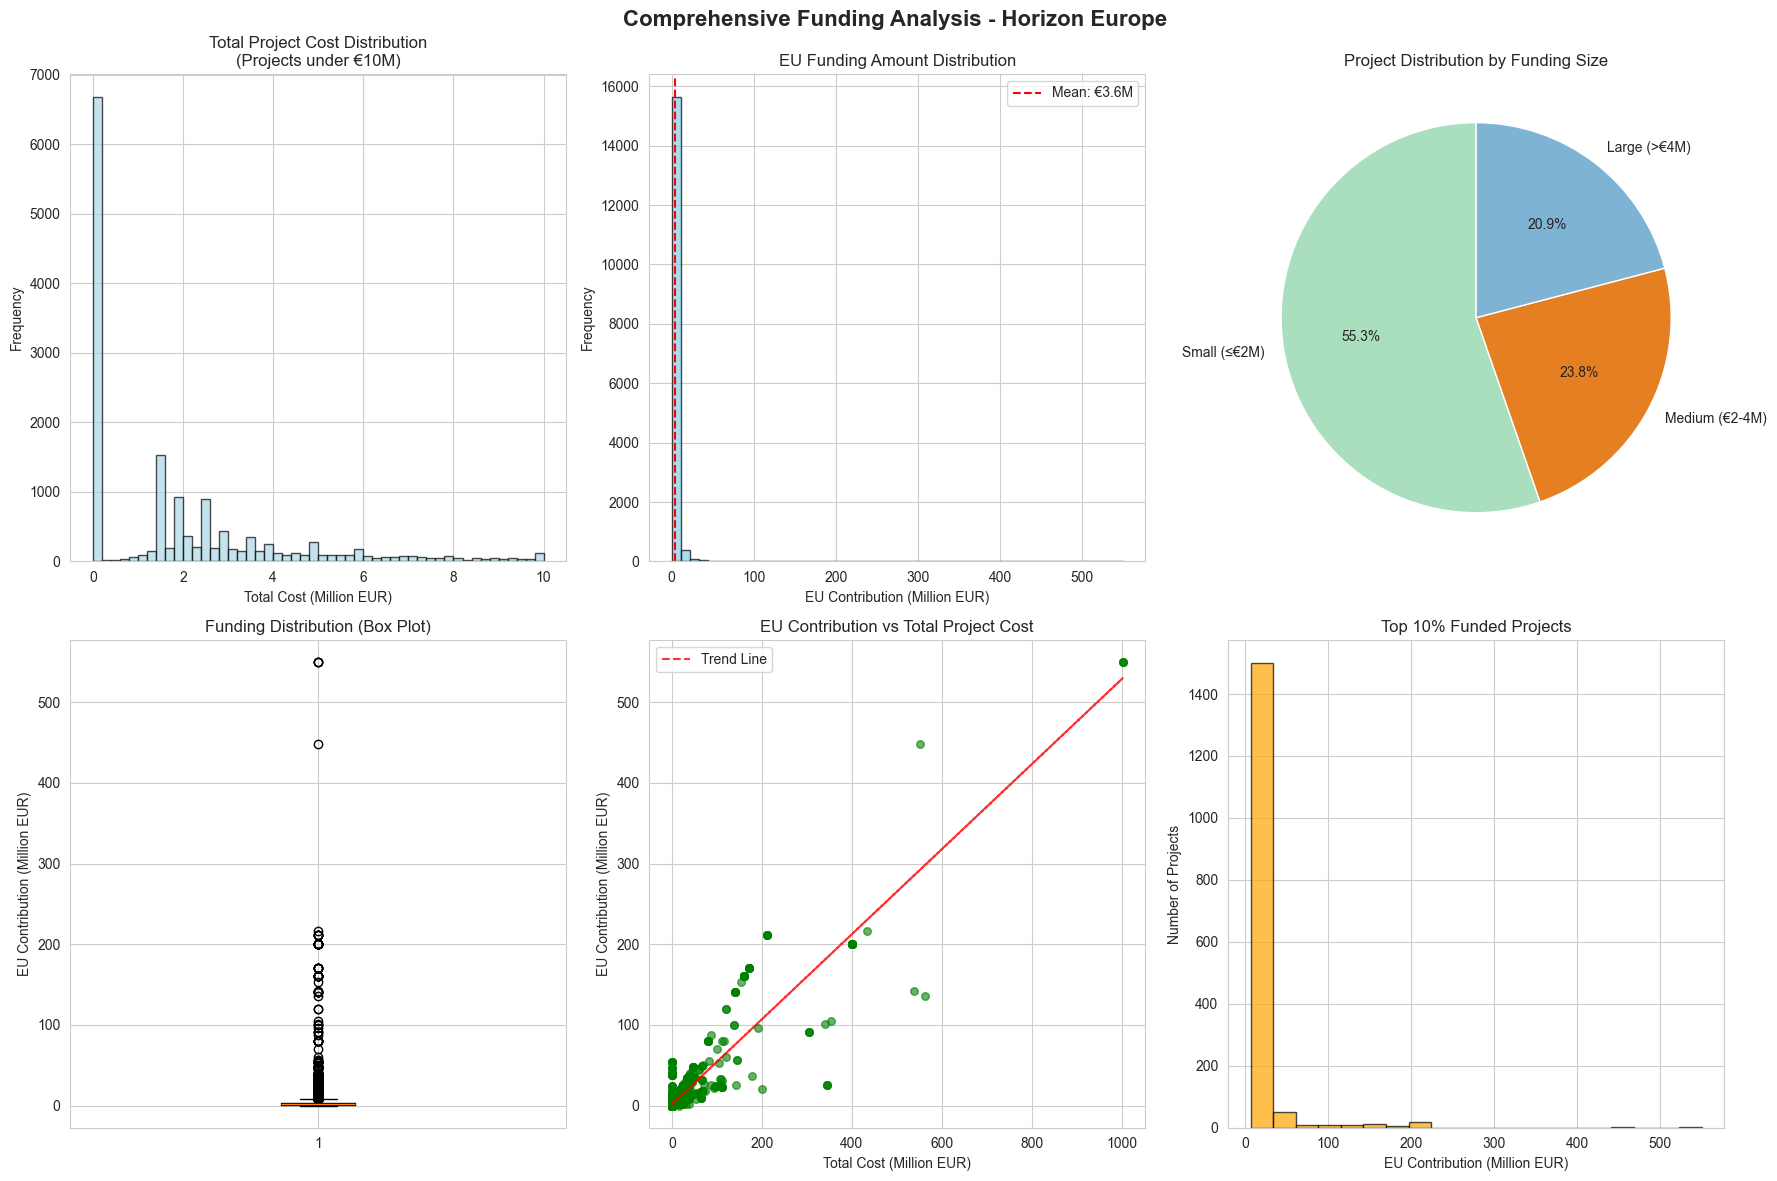

In [11]:

# =============================================================================
# SECTION 3: FUNDING ANALYSIS
# =============================================================================

print("\n=== SECTION 3: COMPREHENSIVE FUNDING ANALYSIS ===")

if 'ecMaxContribution' in df.columns:
    funding_data = df['ecMaxContribution'].dropna()
    
    # Funding categories analysis
    small_projects = (funding_data <= 2_000_000).sum()
    medium_projects = ((funding_data > 2_000_000) & (funding_data <= 4_000_000)).sum()
    large_projects = (funding_data > 4_000_000).sum()
    
    print("--- Funding Distribution Categories ---")
    print(f"Small projects (≤€2M): {small_projects:,} ({small_projects/len(funding_data)*100:.1f}%)")
    print(f"Medium projects (€2-4M): {medium_projects:,} ({medium_projects/len(funding_data)*100:.1f}%)")
    print(f"Large projects (>€4M): {large_projects:,} ({large_projects/len(funding_data)*100:.1f}%)")
    
    # Create comprehensive funding visualization
    fig, axes = plt.subplots(2, 3, figsize=(18, 12))
    fig.suptitle('Comprehensive Funding Analysis - Horizon Europe', fontsize=16, fontweight='bold')
    
    # 1. Total Cost Distribution (projects under €10M for better visibility)
    if 'totalCost' in df.columns:
        cost_data = df[df['totalCost'] < 10_000_000]['totalCost'].dropna()
        axes[0, 0].hist(cost_data/1_000_000, bins=50, alpha=0.7, color='lightblue', edgecolor='black')
        axes[0, 0].set_title('Total Project Cost Distribution\n(Projects under €10M)')
        axes[0, 0].set_xlabel('Total Cost (Million EUR)')
        axes[0, 0].set_ylabel('Frequency')
    
    # 2. EU Funding Distribution
    axes[0, 1].hist(funding_data/1_000_000, bins=50, alpha=0.7, color='skyblue', edgecolor='black')
    axes[0, 1].axvline(funding_data.mean()/1_000_000, color='red', linestyle='--', 
                      label=f'Mean: €{funding_data.mean()/1_000_000:.1f}M')
    axes[0, 1].set_title('EU Funding Amount Distribution')
    axes[0, 1].set_xlabel('EU Contribution (Million EUR)')
    axes[0, 1].set_ylabel('Frequency')
    axes[0, 1].legend()
    
    # 3. Funding Categories Pie Chart
    sizes = [small_projects, medium_projects, large_projects]
    labels = ['Small (≤€2M)', 'Medium (€2-4M)', 'Large (>€4M)']
    colors = ['#A9DFBF', '#E67E22', '#7FB3D3']
    axes[0, 2].pie(sizes, labels=labels, colors=colors, autopct='%1.1f%%', startangle=90)
    axes[0, 2].set_title('Project Distribution by Funding Size')
    
    # 4. Box Plot for Funding Distribution
    axes[1, 0].boxplot(funding_data/1_000_000)
    axes[1, 0].set_ylabel('EU Contribution (Million EUR)')
    axes[1, 0].set_title('Funding Distribution (Box Plot)')
    
    # 5. Cost vs Funding Scatter Plot
    if 'totalCost' in df.columns:
        valid_data = df.dropna(subset=['totalCost', 'ecMaxContribution'])
        axes[1, 1].scatter(valid_data['totalCost']/1_000_000, 
                          valid_data['ecMaxContribution']/1_000_000, 
                          alpha=0.6, s=30, color='green')
        axes[1, 1].set_xlabel('Total Cost (Million EUR)')
        axes[1, 1].set_ylabel('EU Contribution (Million EUR)')
        axes[1, 1].set_title('EU Contribution vs Total Project Cost')
        
        # Add trend line
        z = np.polyfit(valid_data['totalCost'], valid_data['ecMaxContribution'], 1)
        p = np.poly1d(z)
        axes[1, 1].plot(valid_data['totalCost']/1_000_000, p(valid_data['totalCost'])/1_000_000, 
                       "r--", alpha=0.8, label='Trend Line')
        axes[1, 1].legend()
    
    # 6. Top 10% Funded Projects
    top_10_threshold = funding_data.quantile(0.9)
    axes[1, 2].hist(funding_data[funding_data >= top_10_threshold]/1_000_000, 
                   bins=20, alpha=0.7, color='orange', edgecolor='black')
    axes[1, 2].set_xlabel('EU Contribution (Million EUR)')
    axes[1, 2].set_ylabel('Number of Projects')
    axes[1, 2].set_title('Top 10% Funded Projects')
    
    plt.tight_layout()
    plt.show()



=== SECTION 4: GEOGRAPHIC AND ORGANIZATIONAL ANALYSIS ===
--- Organizer Country Analysis ---
Top 15 organizer countries by project count:
 1. DE: 2,148 projects
 2. FR: 1,820 projects
 3. ES: 1,761 projects
 4. IT: 1,322 projects
 5. NL: 1,185 projects
 6. BE: 945 projects
 7. SE: 698 projects
 8. DK: 683 projects
 9. AT: 602 projects
10. NO: 476 projects
11. UK: 405 projects
12. EL: 387 projects
13. PT: 378 projects
14. IL: 376 projects
15. FI: 355 projects

--- Coordinator Country Analysis ---
Top 15 coordinator countries by project count:
 1. DE: 2,178 projects
 2. ES: 2,115 projects
 3. FR: 1,921 projects
 4. IT: 1,680 projects
 5. NL: 1,310 projects
 6. BE: 911 projects
 7. DK: 635 projects
 8. SE: 593 projects
 9. EL: 573 projects
10. NO: 550 projects
11. AT: 525 projects
12. PT: 452 projects
13. IE: 424 projects
14. FI: 416 projects
15. IL: 390 projects


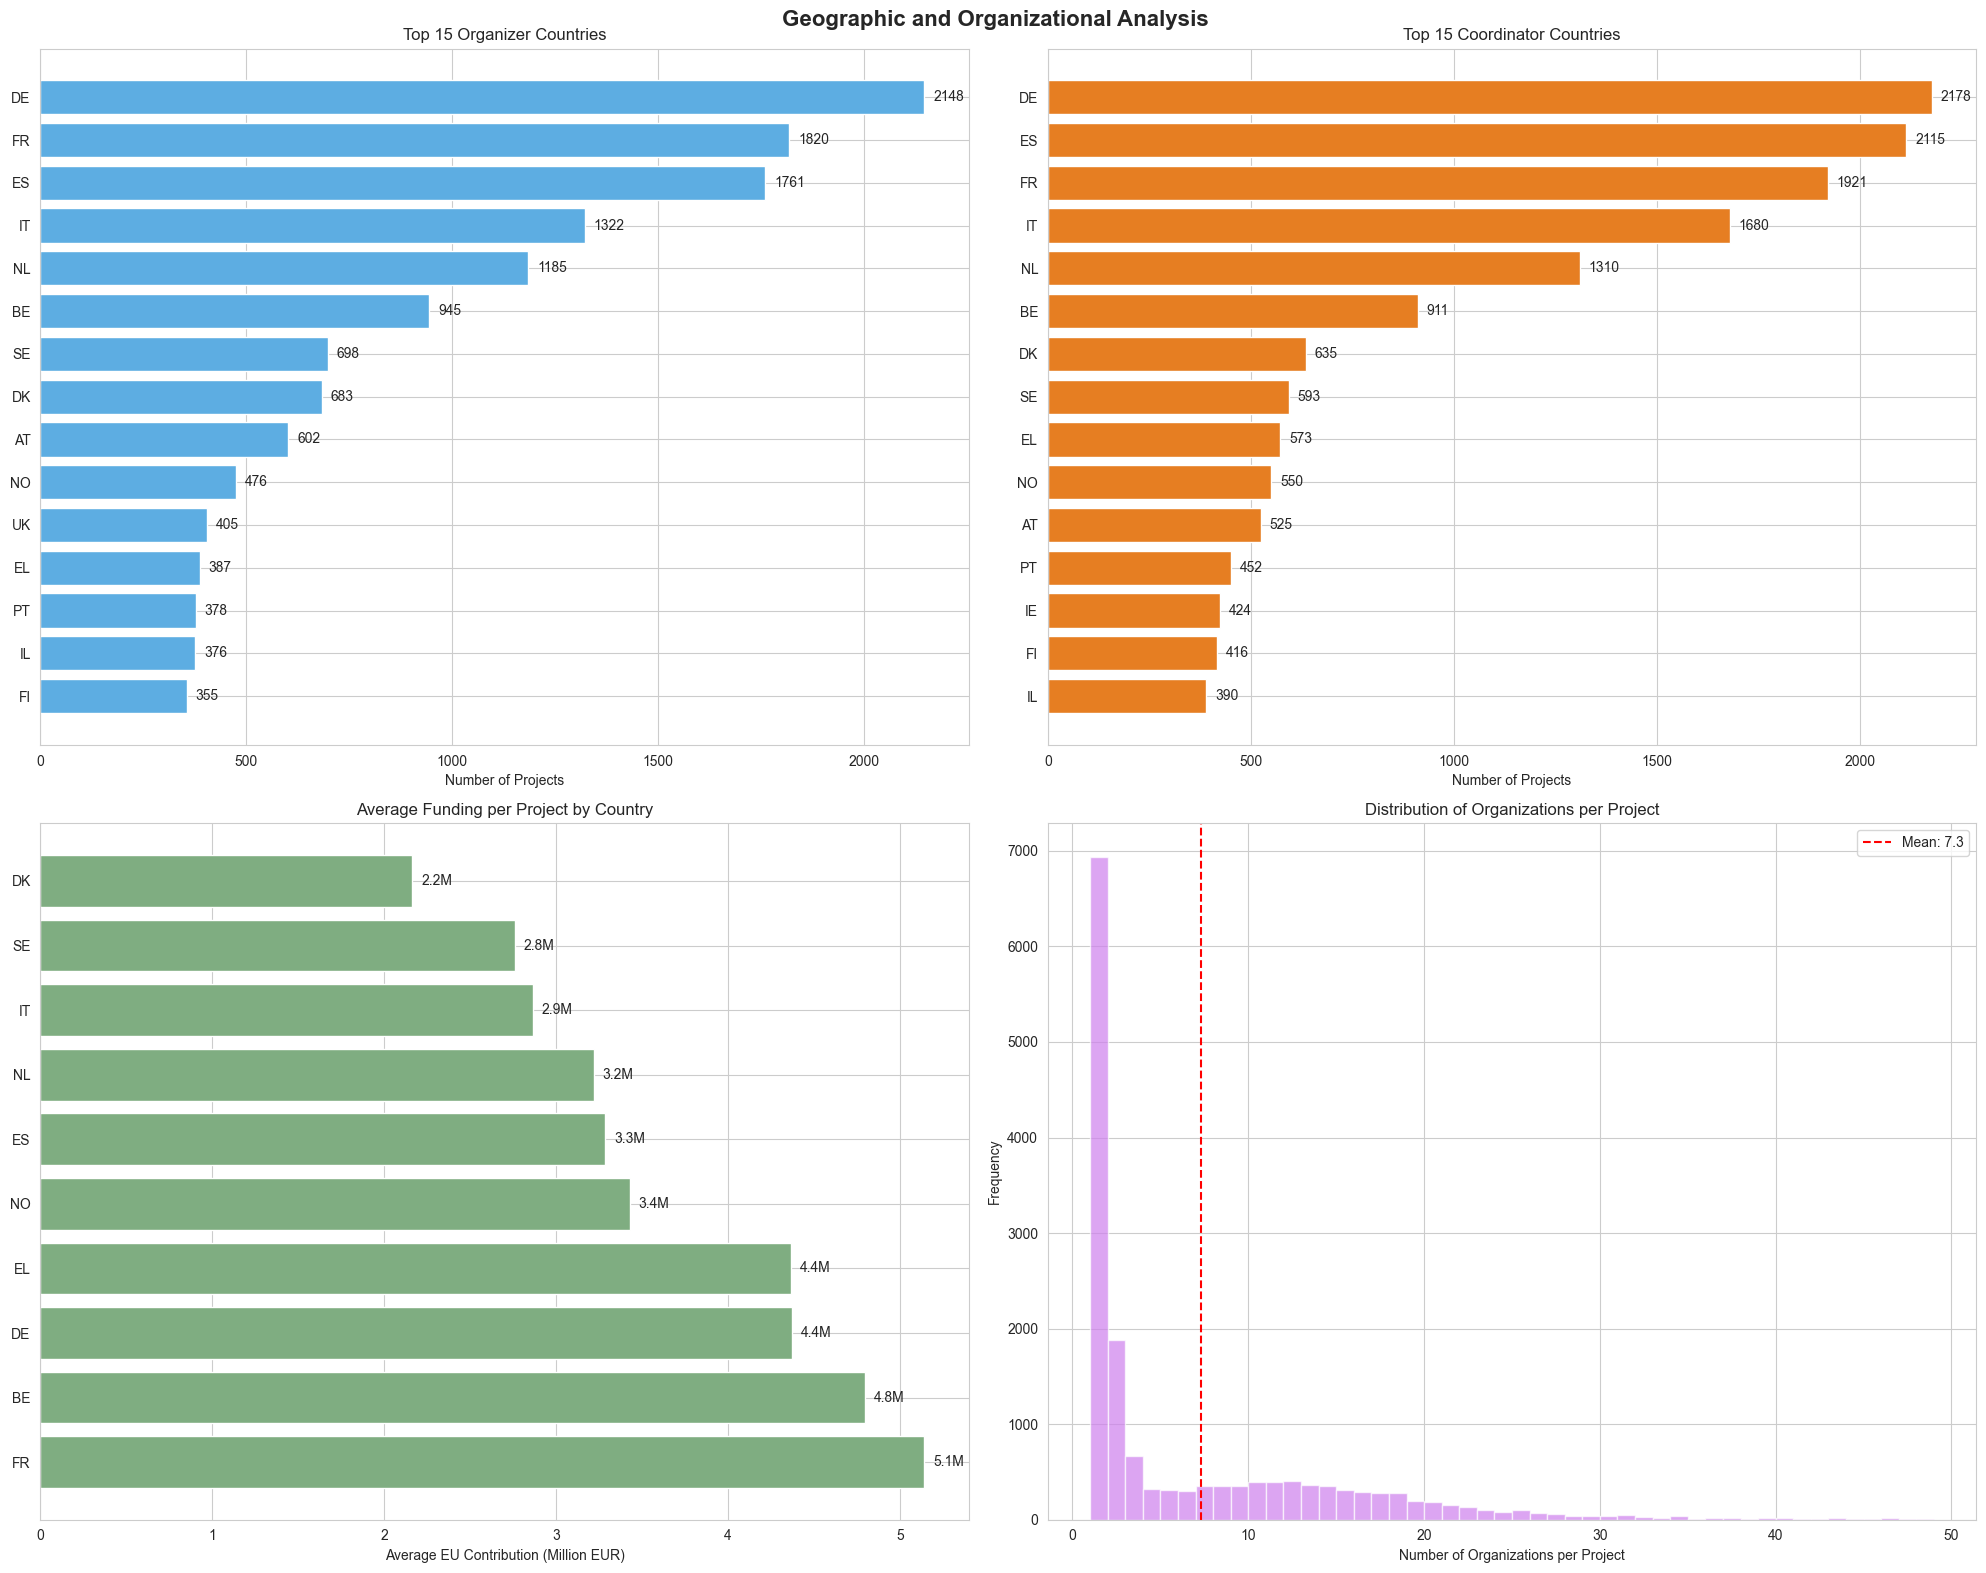


--- Interactive Geographic Visualization ---


 Interactive map generated successfully


In [24]:

# =============================================================================
# SECTION 4: GEOGRAPHIC AND ORGANIZATIONAL ANALYSIS
# =============================================================================

print("\n=== SECTION 4: GEOGRAPHIC AND ORGANIZATIONAL ANALYSIS ===")

# Country analysis
if 'organiser_country' in df.columns:
    print("--- Organizer Country Analysis ---")
    org_country_stats = df['organiser_country'].value_counts().head(15)
    print("Top 15 organizer countries by project count:")
    for i, (country, count) in enumerate(org_country_stats.items(), 1):
        print(f"{i:2d}. {country}: {count:,} projects")

if 'coordinator_country' in df.columns:
    print("\n--- Coordinator Country Analysis ---")
    coord_country_stats = df['coordinator_country'].value_counts().head(15)
    print("Top 15 coordinator countries by project count:")
    for i, (country, count) in enumerate(coord_country_stats.items(), 1):
        print(f"{i:2d}. {country}: {count:,} projects")

# Geographic visualization
fig, axes = plt.subplots(2, 2, figsize=(20, 16))
fig.suptitle('Geographic and Organizational Analysis', fontsize=16, fontweight='bold')

# 1. Organizer Countries Bar Chart
if 'organiser_country' in df.columns:
    axes[0, 0].barh(range(len(org_country_stats)), org_country_stats.values, color='#5DADE2')
    axes[0, 0].set_yticks(range(len(org_country_stats)))
    axes[0, 0].set_yticklabels(org_country_stats.index)
    axes[0, 0].set_xlabel('Number of Projects')
    axes[0, 0].set_title('Top 15 Organizer Countries')
    axes[0, 0].invert_yaxis()
    
    # Add value labels
    for i, v in enumerate(org_country_stats.values):
        axes[0, 0].text(v + max(org_country_stats.values)*0.01, i, str(v), va='center', ha='left')

# 2. Coordinator Countries Bar Chart
if 'coordinator_country' in df.columns:
    axes[0, 1].barh(range(len(coord_country_stats)), coord_country_stats.values, color='#E67E22')
    axes[0, 1].set_yticks(range(len(coord_country_stats)))
    axes[0, 1].set_yticklabels(coord_country_stats.index)
    axes[0, 1].set_xlabel('Number of Projects')
    axes[0, 1].set_title('Top 15 Coordinator Countries')
    axes[0, 1].invert_yaxis()
    
    # Add value labels
    for i, v in enumerate(coord_country_stats.values):
        axes[0, 1].text(v + max(coord_country_stats.values)*0.01, i, str(v), va='center', ha='left')

# 3. Average Funding by Country
if 'coordinator_country' in df.columns and 'ecMaxContribution' in df.columns:
    top_countries = coord_country_stats.index[:10]
    avg_funding = df[df['coordinator_country'].isin(top_countries)].groupby(
        'coordinator_country')['ecMaxContribution'].mean() / 1_000_000
    avg_funding = avg_funding.sort_values(ascending=True)
    
    axes[1, 0].barh(range(len(avg_funding)), avg_funding.values, color="#7FAD81")
    axes[1, 0].set_yticks(range(len(avg_funding)))
    axes[1, 0].set_yticklabels(avg_funding.index)
    axes[1, 0].set_xlabel('Average EU Contribution (Million EUR)')
    axes[1, 0].set_title('Average Funding per Project by Country')
    axes[1, 0].invert_yaxis()
    
    # Add value labels
    for i, v in enumerate(avg_funding.values):
        axes[1, 0].text(v + max(avg_funding.values)*0.01, i, f'{v:.1f}M', va='center', ha='left')

# 4. Organizations per Project Distribution
if 'org_count' in df.columns:
    axes[1, 1].hist(df['org_count'], bins=range(1, min(50, int(df['org_count'].max())+2)), 
                   alpha=0.7, color="#CE7FEDCB")
    axes[1, 1].set_xlabel('Number of Organizations per Project')
    axes[1, 1].set_ylabel('Frequency')
    axes[1, 1].set_title('Distribution of Organizations per Project')
    axes[1, 1].axvline(df['org_count'].mean(), color='red', linestyle='--', 
                      label=f'Mean: {df["org_count"].mean():.1f}')
    axes[1, 1].legend()

plt.tight_layout()
plt.show()

# Interactive Geographic Map (if data available)
if 'org_count' in df.columns and 'iso_3' in df.columns:
    print("\n--- Interactive Geographic Visualization ---")
    
    # Prepare data for choropleth map
    country_org_data = df.groupby(['coordinator_country', 'iso_3'])['org_count'].sum().reset_index()
    country_org_data = country_org_data.dropna()
    
    if len(country_org_data) > 0:
        fig_map = px.choropleth(
            country_org_data,
            locations="iso_3",
            locationmode="ISO-3",
            color="org_count",
            title="Total Participating Organizations by Country (Europe)",
            color_continuous_scale="Blues",
            scope="europe",
            hover_name="coordinator_country",
            labels={'org_count': 'Organization Count'}
        )
        fig_map.show()
        print(" Interactive map generated successfully")
    else:
        print(" Insufficient data for geographic mapping")



=== SECTION 5: FUNDING SCHEMES ANALYSIS ===
--- Funding Schemes Overview ---
Top 10 funding schemes by project count:
 1. HORIZON-TMA-MSCA-PF-EF: 3,370 projects
 2. HORIZON-ERC: 3,073 projects
 3. HORIZON-RIA: 2,539 projects
 4. HORIZON-CSA: 1,386 projects
 5. HORIZON-IA: 996 projects
 6. HORIZON-ERC-POC: 613 projects
 7. HORIZON-EIC: 546 projects
 8. HORIZON-EIC-ACC-BF: 510 projects
 9. HORIZON-TMA-MSCA-PF-GF: 414 projects
10. HORIZON-JU-RIA: 385 projects

Top 10 funding schemes by total funding:
HORIZON-RIA:
  • Total: €14.6B
  • Average: €5.7M
  • Projects: 2,539.0
HORIZON-IA:
  • Total: €7.3B
  • Average: €7.3M
  • Projects: 996.0
HORIZON-EIT-KIC:
  • Total: €6.2B
  • Average: €94.0M
  • Projects: 66.0
HORIZON-ERC:
  • Total: €5.8B
  • Average: €1.9M
  • Projects: 3,073.0
HORIZON-JU-IA:
  • Total: €3.8B
  • Average: €17.8M
  • Projects: 212.0
HORIZON-CSA:
  • Total: €3.4B
  • Average: €2.5M
  • Projects: 1,386.0
HORIZON-AG:
  • Total: €3.4B
  • Average: €11.2M
  • Projects: 302.0


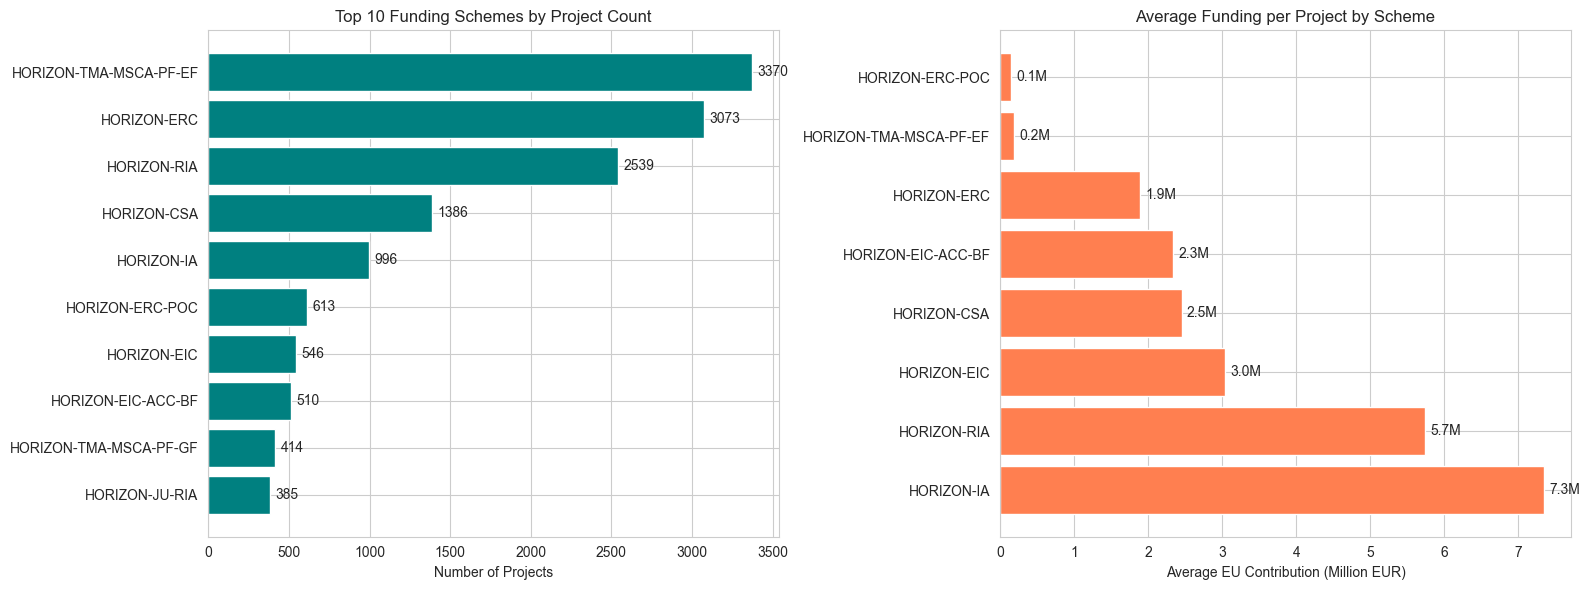

In [15]:

# =============================================================================
# SECTION 5: FUNDING SCHEMES ANALYSIS
# =============================================================================

print("\n=== SECTION 5: FUNDING SCHEMES ANALYSIS ===")

if 'fundingScheme' in df.columns:
    print("--- Funding Schemes Overview ---")
    
    # Project count analysis
    top_schemes = df['fundingScheme'].value_counts().head(10)
    print("Top 10 funding schemes by project count:")
    for i, (scheme, count) in enumerate(top_schemes.items(), 1):
        print(f"{i:2d}. {scheme}: {count:,} projects")
    
    # Financial analysis by scheme
    if 'ecMaxContribution' in df.columns:
        scheme_funding = df.groupby('fundingScheme')['ecMaxContribution'].agg([
            'count', 'mean', 'sum'
        ]).sort_values('sum', ascending=False).head(10)
        
        print(f"\nTop 10 funding schemes by total funding:")
        for scheme, row in scheme_funding.iterrows():
            print(f"{scheme}:")
            print(f"  • Total: €{row['sum']/1_000_000_000:.1f}B")
            print(f"  • Average: €{row['mean']/1_000_000:.1f}M")
            print(f"  • Projects: {row['count']:,}")
    
    # Visualization
    fig, axes = plt.subplots(1, 2, figsize=(16, 6))
    
    # Horizontal bar chart for funding schemes
    axes[0].barh(range(len(top_schemes)), top_schemes.values, color='teal')
    axes[0].set_yticks(range(len(top_schemes)))
    axes[0].set_yticklabels([scheme[:30] + '...' if len(scheme) > 30 else scheme 
                            for scheme in top_schemes.index])
    axes[0].set_xlabel('Number of Projects')
    axes[0].set_title('Top 10 Funding Schemes by Project Count')
    axes[0].invert_yaxis()
    
    # Add value labels
    for i, v in enumerate(top_schemes.values):
        axes[0].text(v + max(top_schemes.values)*0.01, i, str(v), va='center', ha='left')
    
    # Average funding by scheme (if data available)
    if 'ecMaxContribution' in df.columns:
        top_scheme_names = top_schemes.index[:8]  # Reduced for better visualization
        avg_scheme_funding = df[df['fundingScheme'].isin(top_scheme_names)].groupby(
            'fundingScheme')['ecMaxContribution'].mean() / 1_000_000
        avg_scheme_funding = avg_scheme_funding.sort_values(ascending=True)
        
        axes[1].barh(range(len(avg_scheme_funding)), avg_scheme_funding.values, color='coral')
        axes[1].set_yticks(range(len(avg_scheme_funding)))
        axes[1].set_yticklabels([scheme[:25] + '...' if len(scheme) > 25 else scheme 
                                for scheme in avg_scheme_funding.index])
        axes[1].set_xlabel('Average EU Contribution (Million EUR)')
        axes[1].set_title('Average Funding per Project by Scheme')
        axes[1].invert_yaxis()
        
        # Add value labels
        for i, v in enumerate(avg_scheme_funding.values):
            axes[1].text(v + max(avg_scheme_funding.values)*0.01, i, f'{v:.1f}M', 
                        va='center', ha='left')
    
    plt.tight_layout()
    plt.show()



=== SECTION 6: TEMPORAL ANALYSIS ===
Project Duration Statistics:
• Average duration: 1227 days (3.4 years)
• Median duration: 1095 days (3.0 years)
• Standard deviation: 473 days

Start Month Analysis:
• Most common start month: 1 (Jan)
• Least common start month: 8 (Aug)


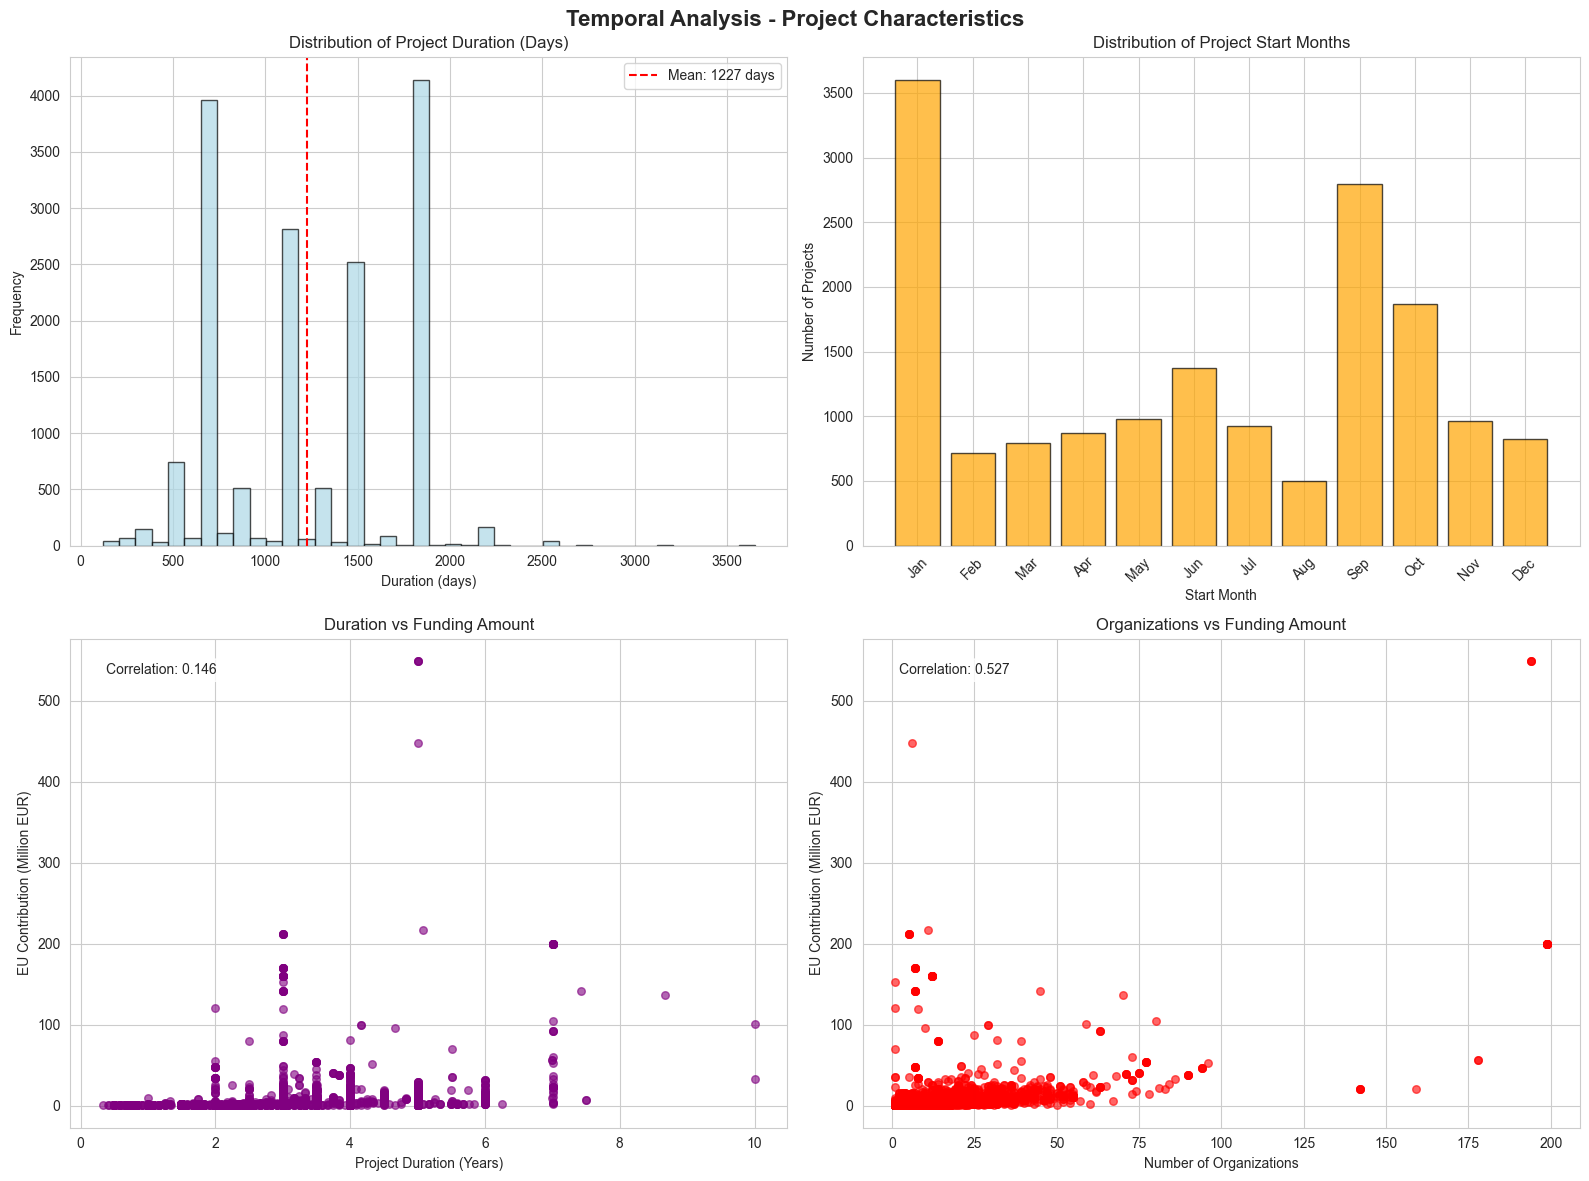

In [16]:

# =============================================================================
# SECTION 6: TEMPORAL ANALYSIS
# =============================================================================

print("\n=== SECTION 6: TEMPORAL ANALYSIS ===")

# Create temporal analysis plots
fig, axes = plt.subplots(2, 2, figsize=(16, 12))
fig.suptitle('Temporal Analysis - Project Characteristics', fontsize=16, fontweight='bold')

# 1. Project Duration Distribution
if 'duration_days' in df.columns:
    duration_data = df['duration_days'].dropna()
    axes[0, 0].hist(duration_data, bins=40, alpha=0.7, color='lightblue', edgecolor='black')
    axes[0, 0].axvline(duration_data.mean(), color='red', linestyle='--', 
                      label=f'Mean: {duration_data.mean():.0f} days')
    axes[0, 0].set_title('Distribution of Project Duration (Days)')
    axes[0, 0].set_xlabel('Duration (days)')
    axes[0, 0].set_ylabel('Frequency')
    axes[0, 0].legend()
    
    print(f"Project Duration Statistics:")
    print(f"• Average duration: {duration_data.mean():.0f} days ({duration_data.mean()/365:.1f} years)")
    print(f"• Median duration: {duration_data.median():.0f} days ({duration_data.median()/365:.1f} years)")
    print(f"• Standard deviation: {duration_data.std():.0f} days")

# 2. Start Month Distribution
if 'startmonth' in df.columns:
    month_data = df['startmonth'].dropna()
    month_counts = month_data.value_counts().sort_index()
    
    axes[0, 1].bar(month_counts.index, month_counts.values, alpha=0.7, color='orange', edgecolor='black')
    axes[0, 1].set_title('Distribution of Project Start Months')
    axes[0, 1].set_xlabel('Start Month')
    axes[0, 1].set_ylabel('Number of Projects')
    axes[0, 1].set_xticks(range(1, 13))
    
    # Add month labels
    month_labels = ['Jan', 'Feb', 'Mar', 'Apr', 'May', 'Jun',
                   'Jul', 'Aug', 'Sep', 'Oct', 'Nov', 'Dec']
    axes[0, 1].set_xticklabels(month_labels, rotation=45)
    
    print(f"\nStart Month Analysis:")
    print(f"• Most common start month: {month_counts.idxmax()} ({month_labels[month_counts.idxmax()-1]})")
    print(f"• Least common start month: {month_counts.idxmin()} ({month_labels[month_counts.idxmin()-1]})")

# 3. Duration vs Funding Correlation
if 'duration_days' in df.columns and 'ecMaxContribution' in df.columns:
    valid_data = df.dropna(subset=['duration_days', 'ecMaxContribution'])
    if len(valid_data) > 0:
        axes[1, 0].scatter(valid_data['duration_days']/365, valid_data['ecMaxContribution']/1_000_000, 
                          alpha=0.6, s=30, color='purple')
        axes[1, 0].set_xlabel('Project Duration (Years)')
        axes[1, 0].set_ylabel('EU Contribution (Million EUR)')
        axes[1, 0].set_title('Duration vs Funding Amount')
        
        # Calculate and display correlation
        correlation = valid_data['duration_days'].corr(valid_data['ecMaxContribution'])
        axes[1, 0].text(0.05, 0.95, f'Correlation: {correlation:.3f}', 
                       transform=axes[1, 0].transAxes, verticalalignment='top',
                       bbox=dict(boxstyle='round', facecolor='white', alpha=0.8))

# 4. Organizations vs Funding Correlation
if 'org_count' in df.columns and 'ecMaxContribution' in df.columns:
    valid_data = df.dropna(subset=['org_count', 'ecMaxContribution'])
    if len(valid_data) > 0:
        axes[1, 1].scatter(valid_data['org_count'], valid_data['ecMaxContribution']/1_000_000, 
                          alpha=0.6, s=30, color='red')
        axes[1, 1].set_xlabel('Number of Organizations')
        axes[1, 1].set_ylabel('EU Contribution (Million EUR)')
        axes[1, 1].set_title('Organizations vs Funding Amount')
        
        # Calculate and display correlation
        correlation = valid_data['org_count'].corr(valid_data['ecMaxContribution'])
        axes[1, 1].text(0.05, 0.95, f'Correlation: {correlation:.3f}', 
                       transform=axes[1, 1].transAxes, verticalalignment='top',
                       bbox=dict(boxstyle='round', facecolor='white', alpha=0.8))

plt.tight_layout()
plt.show()



=== SECTION 7: CORRELATION ANALYSIS ===
Correlation Matrix:
                 Organizations  Duration (days)  EU Contribution  Total Cost
Organizations            1.000            0.179            0.527       0.536
Duration (days)          0.179            1.000            0.146       0.142
EU Contribution          0.527            0.146            1.000       0.910
Total Cost               0.536            0.142            0.910       1.000


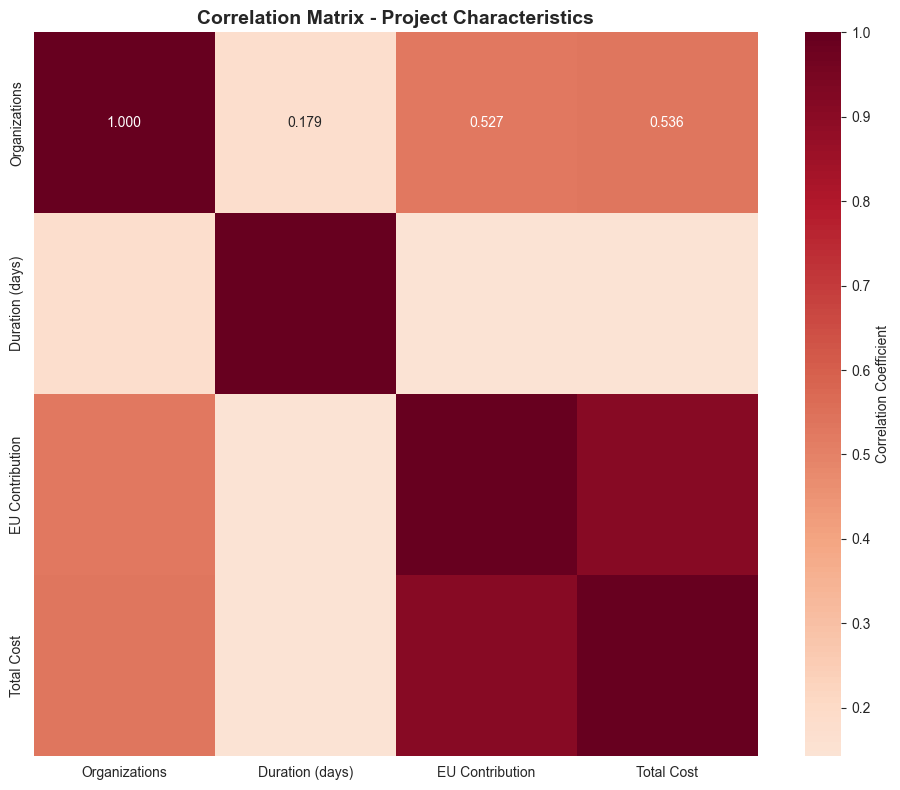


Key Correlation Insights:
• Organizations vs Funding: 0.527
  → Multi-organizational projects tend to receive more funding
• Duration vs Funding: 0.146
  → Weak correlation between project duration and funding
• Total Cost vs EU Funding: 0.910
  → Strong positive correlation between project cost and EU contribution


In [17]:

# =============================================================================
# SECTION 7: CORRELATION ANALYSIS
# =============================================================================

print("\n=== SECTION 7: CORRELATION ANALYSIS ===")

# Prepare correlation matrix
numeric_columns = []
correlation_labels = []

if 'org_count' in df.columns:
    numeric_columns.append('org_count')
    correlation_labels.append('Organizations')

if 'duration_days' in df.columns:
    numeric_columns.append('duration_days')
    correlation_labels.append('Duration (days)')

if 'ecMaxContribution' in df.columns:
    numeric_columns.append('ecMaxContribution')
    correlation_labels.append('EU Contribution')

if 'totalCost' in df.columns:
    numeric_columns.append('totalCost')
    correlation_labels.append('Total Cost')

if len(numeric_columns) >= 2:
    correlation_data = df[numeric_columns].corr()
    correlation_data.columns = correlation_labels
    correlation_data.index = correlation_labels
    
    print("Correlation Matrix:")
    print(correlation_data.round(3))
    
    # Correlation heatmap
    plt.figure(figsize=(10, 8))
    sns.heatmap(correlation_data, annot=True, cmap='RdBu_r', center=0, 
                square=True, fmt='.3f', cbar_kws={'label': 'Correlation Coefficient'})
    plt.title('Correlation Matrix - Project Characteristics', fontsize=14, fontweight='bold')
    plt.tight_layout()
    plt.show()
    
    # Key correlations insights
    print("\nKey Correlation Insights:")
    if 'Organizations' in correlation_data.columns and 'EU Contribution' in correlation_data.columns:
        org_funding_corr = correlation_data.loc['Organizations', 'EU Contribution']
        print(f"• Organizations vs Funding: {org_funding_corr:.3f}")
        if org_funding_corr > 0.3:
            print("  → Multi-organizational projects tend to receive more funding")
        elif org_funding_corr < -0.3:
            print("  → Smaller collaborations tend to receive more funding")
        else:
            print("  → Weak correlation between organization count and funding")
    
    if 'Duration (days)' in correlation_data.columns and 'EU Contribution' in correlation_data.columns:
        duration_funding_corr = correlation_data.loc['Duration (days)', 'EU Contribution']
        print(f"• Duration vs Funding: {duration_funding_corr:.3f}")
        if duration_funding_corr > 0.3:
            print("  → Longer projects tend to receive more funding")
        elif duration_funding_corr < -0.3:
            print("  → Shorter projects tend to receive more funding")
        else:
            print("  → Weak correlation between project duration and funding")
    
    if 'Total Cost' in correlation_data.columns and 'EU Contribution' in correlation_data.columns:
        cost_funding_corr = correlation_data.loc['Total Cost', 'EU Contribution']
        print(f"• Total Cost vs EU Funding: {cost_funding_corr:.3f}")
        if cost_funding_corr > 0.7:
            print("  → Strong positive correlation between project cost and EU contribution")


In [18]:

# =============================================================================
# SECTION 8: ADVANCED STATISTICAL ANALYSIS
# =============================================================================

print("\n=== SECTION 8: ADVANCED STATISTICAL ANALYSIS ===")

# Funding efficiency analysis by country
if 'coordinator_country' in df.columns and 'ecMaxContribution' in df.columns:
    print("--- Funding Efficiency Analysis by Country ---")
    
    country_analysis = df.groupby('coordinator_country').agg({
        'ecMaxContribution': ['count', 'sum', 'mean', 'median', 'std']
    }).round(0)
    
    # Flatten column names
    country_analysis.columns = ['Project_Count', 'Total_Funding', 'Mean_Funding', 
                               'Median_Funding', 'Funding_StdDev']
    
    # Calculate funding efficiency metrics
    country_analysis['Funding_per_Million_EUR'] = country_analysis['Total_Funding'] / 1_000_000
    country_analysis['CV_Funding'] = country_analysis['Funding_StdDev'] / country_analysis['Mean_Funding']
    
    # Filter countries with at least 10 projects for meaningful analysis
    significant_countries = country_analysis[country_analysis['Project_Count'] >= 10].copy()
    significant_countries = significant_countries.sort_values('Total_Funding', ascending=False)
    
    print(f"Countries with significant funding (≥10 projects):")
    print(f"Top 10 by total funding:")
    for i, (country, row) in enumerate(significant_countries.head(10).iterrows(), 1):
        print(f"{i:2d}. {country}:")
        print(f"    • Projects: {row['Project_Count']:,}")
        print(f"    • Total: €{row['Funding_per_Million_EUR']:,.0f}M")
        print(f"    • Average: €{row['Mean_Funding']/1_000_000:.1f}M")
        print(f"    • Variability: {row['CV_Funding']:.2f}")

# Project size distribution analysis
if 'ecMaxContribution' in df.columns:
    print("\n--- Project Size Distribution Analysis ---")
    
    funding_data = df['ecMaxContribution'].dropna()
    
    # Define size categories
    size_categories = {
        'Micro (≤€100K)': (funding_data <= 100_000).sum(),
        'Small (€100K-€500K)': ((funding_data > 100_000) & (funding_data <= 500_000)).sum(),
        'Medium-Small (€500K-€1M)': ((funding_data > 500_000) & (funding_data <= 1_000_000)).sum(),
        'Medium (€1M-€2M)': ((funding_data > 1_000_000) & (funding_data <= 2_000_000)).sum(),
        'Medium-Large (€2M-€5M)': ((funding_data > 2_000_000) & (funding_data <= 5_000_000)).sum(),
        'Large (€5M-€10M)': ((funding_data > 5_000_000) & (funding_data <= 10_000_000)).sum(),
        'Mega (>€10M)': (funding_data > 10_000_000).sum()
    }
    
    print("Detailed project size distribution:")
    total_projects = len(funding_data)
    cumulative_pct = 0
    
    for category, count in size_categories.items():
        percentage = (count / total_projects) * 100
        cumulative_pct += percentage
        print(f"• {category}: {count:,} projects ({percentage:.1f}%, cumulative: {cumulative_pct:.1f}%)")

# Statistical testing for funding differences
try:
    from scipy import stats
    scipy_available = True
except ImportError:
    print(" SciPy not available for advanced statistical tests")
    scipy_available = False

if scipy_available and 'coordinator_country' in df.columns and 'ecMaxContribution' in df.columns:
    print("\n--- Statistical Significance Testing ---")
    
    # Compare funding between top 2 countries
    top_countries = df['coordinator_country'].value_counts().head(2).index
    if len(top_countries) == 2:
        country1_funding = df[df['coordinator_country'] == top_countries[0]]['ecMaxContribution'].dropna()
        country2_funding = df[df['coordinator_country'] == top_countries[1]]['ecMaxContribution'].dropna()
        
        if len(country1_funding) > 0 and len(country2_funding) > 0:
            # Perform t-test
            t_stat, p_value = stats.ttest_ind(country1_funding, country2_funding)
            
            print(f"Funding comparison between {top_countries[0]} and {top_countries[1]}:")
            print(f"• {top_countries[0]} average: €{country1_funding.mean()/1_000_000:.2f}M")
            print(f"• {top_countries[1]} average: €{country2_funding.mean()/1_000_000:.2f}M")
            print(f"• T-statistic: {t_stat:.3f}")
            print(f"• P-value: {p_value:.6f}")
            
            if p_value < 0.05:
                print("• Result: Statistically significant difference in funding")
            else:
                print("• Result: No statistically significant difference in funding")



=== SECTION 8: ADVANCED STATISTICAL ANALYSIS ===
--- Funding Efficiency Analysis by Country ---
Countries with significant funding (≥10 projects):
Top 10 by total funding:
 1. FR:
    • Projects: 1,921.0
    • Total: €9,878M
    • Average: €5.1M
    • Variability: 3.86
 2. DE:
    • Projects: 2,178.0
    • Total: €9,525M
    • Average: €4.4M
    • Variability: 5.26
 3. ES:
    • Projects: 2,115.0
    • Total: €6,946M
    • Average: €3.3M
    • Variability: 2.52
 4. IT:
    • Projects: 1,680.0
    • Total: €4,809M
    • Average: €2.9M
    • Variability: 2.44
 5. BE:
    • Projects: 911.0
    • Total: €4,369M
    • Average: €4.8M
    • Variability: 4.32
 6. NL:
    • Projects: 1,310.0
    • Total: €4,214M
    • Average: €3.2M
    • Variability: 2.46
 7. EL:
    • Projects: 573.0
    • Total: €2,503M
    • Average: €4.4M
    • Variability: 0.76
 8. NO:
    • Projects: 550.0
    • Total: €1,886M
    • Average: €3.4M
    • Variability: 1.51
 9. FI:
    • Projects: 416.0
    • Total: €1,738

In [19]:

# =============================================================================
# SECTION 9: COMPREHENSIVE SUMMARY AND INSIGHTS
# =============================================================================

print("\n" + "=" * 70)
print("COMPREHENSIVE ANALYSIS SUMMARY AND KEY INSIGHTS")
print("=" * 70)

# Calculate key metrics for summary
total_projects = len(df)
if 'ecMaxContribution' in df.columns:
    funding_data = df['ecMaxContribution'].dropna()
    total_funding = funding_data.sum()
    avg_funding = funding_data.mean()
    median_funding = funding_data.median()

print(f"\n1. DATASET OVERVIEW:")
print(f"   • Total projects analyzed: {total_projects:,}")
if 'ecMaxContribution' in df.columns:
    print(f"   • Total EU funding: €{total_funding/1_000_000_000:.1f} billion")
    print(f"   • Average project funding: €{avg_funding/1_000_000:.2f} million")
    print(f"   • Median project funding: €{median_funding/1_000_000:.2f} million")

if 'ecMaxContribution' in df.columns:
    funding_data = df['ecMaxContribution'].dropna()
    small_pct = (funding_data <= 2_000_000).mean() * 100
    large_pct = (funding_data > 4_000_000).mean() * 100
    
    print(f"\n2. FUNDING DISTRIBUTION INSIGHTS:")
    print(f"   • {small_pct:.1f}% of projects are small-scale (≤€2M funding)")
    print(f"   • {large_pct:.1f}% of projects are large-scale (>€4M funding)")
    print(f"   • EU prioritizes distributed funding over mega-projects")
    
    # Funding concentration analysis
    funding_gini = None
    try:
        sorted_funding = np.sort(funding_data)
        n = len(sorted_funding)
        cumsum = np.cumsum(sorted_funding)
        funding_gini = (2 * np.sum((np.arange(1, n+1) * sorted_funding))) / (n * np.sum(sorted_funding)) - (n + 1) / n
        print(f"   • Funding inequality (Gini coefficient): {funding_gini:.3f}")
        if funding_gini < 0.4:
            print("     → Relatively equal funding distribution")
        elif funding_gini > 0.6:
            print("     → High funding concentration among few projects")
        else:
            print("     → Moderate funding inequality")
    except:
        pass

if 'coordinator_country' in df.columns:
    top_country = df['coordinator_country'].value_counts().index[0]
    top_count = df['coordinator_country'].value_counts().iloc[0]
    top_3_countries = df['coordinator_country'].value_counts().head(3)
    top_3_share = (top_3_countries.sum() / len(df)) * 100
    
    print(f"\n3. GEOGRAPHIC CONCENTRATION:")
    print(f"   • Leading country: {top_country} with {top_count:,} projects")
    print(f"   • Top 3 countries account for {top_3_share:.1f}% of all projects")
    print(f"   • Research funding shows significant geographic clustering")

if 'org_count' in df.columns:
    avg_orgs = df['org_count'].mean()
    single_org_pct = (df['org_count'] == 1).mean() * 100
    multi_org_pct = (df['org_count'] > 5).mean() * 100
    
    print(f"\n4. COLLABORATION PATTERNS:")
    print(f"   • Average organizations per project: {avg_orgs:.1f}")
    print(f"   • {single_org_pct:.1f}% are single-organization projects")
    print(f"   • {multi_org_pct:.1f}% involve large collaborations (>5 organizations)")

# Correlation insights
if 'org_count' in df.columns and 'ecMaxContribution' in df.columns:
    correlation = df['org_count'].corr(df['ecMaxContribution'])
    print(f"\n5. FUNDING-COLLABORATION RELATIONSHIP:")
    print(f"   • Organizations-Funding correlation: {correlation:.3f}")
    if correlation > 0.3:
        print(f"   • Multi-organizational projects tend to receive significantly more funding")
    elif correlation > 0.1:
        print(f"   • Moderate positive relationship between collaboration and funding")
    else:
        print(f"   • Weak relationship between organization count and funding")

if 'duration_days' in df.columns:
    avg_duration = df['duration_days'].mean() / 365
    short_projects_pct = (df['duration_days'] <= 365).mean() * 100
    long_projects_pct = (df['duration_days'] > 1095).mean() * 100  # >3 years
    
    print(f"\n6. PROJECT DURATION CHARACTERISTICS:")
    print(f"   • Average project duration: {avg_duration:.1f} years")
    print(f"   • {short_projects_pct:.1f}% are short-term projects (≤1 year)")
    print(f"   • {long_projects_pct:.1f}% are long-term projects (>3 years)")

if 'startmonth' in df.columns:
    month_data = df['startmonth'].dropna()
    if len(month_data) > 0:
        most_common_month = month_data.mode().iloc[0] if len(month_data.mode()) > 0 else None
        month_names = ['', 'January', 'February', 'March', 'April', 'May', 'June',
                      'July', 'August', 'September', 'October', 'November', 'December']
        
        if most_common_month:
            print(f"\n7. TEMPORAL PATTERNS:")
            print(f"   • Most common start month: {month_names[most_common_month]}")
            
            # Calculate seasonality
            spring_summer = month_data.isin([3, 4, 5, 6, 7, 8]).mean() * 100
            fall_winter = month_data.isin([9, 10, 11, 12, 1, 2]).mean() * 100
            
            print(f"   • Spring/Summer starts: {spring_summer:.1f}%")
            print(f"   • Fall/Winter starts: {fall_winter:.1f}%")

if 'fundingScheme' in df.columns:
    scheme_diversity = df['fundingScheme'].nunique()
    top_scheme = df['fundingScheme'].value_counts().index[0]
    top_scheme_pct = (df['fundingScheme'].value_counts().iloc[0] / len(df)) * 100
    
    print(f"\n8. FUNDING SCHEME DIVERSITY:")
    print(f"   • Total number of funding schemes: {scheme_diversity}")
    print(f"   • Most common scheme: {top_scheme}")
    print(f"   • Top scheme represents {top_scheme_pct:.1f}% of all projects")

print(f"\n9. STRATEGIC IMPLICATIONS:")
print(f"   • EU research policy emphasizes collaboration and networking")
print(f"   • Geographic distribution reflects existing research infrastructure")
print(f"   • Funding strategy balances accessibility with excellence")
print(f"   • Multi-organizational approaches are increasingly important")

print(f"\n10. RECOMMENDATIONS FOR STAKEHOLDERS:")
print(f"   • Applicants: Consider multi-institutional partnerships")
print(f"   • Policy makers: Address geographic imbalances if needed")
print(f"   • Researchers: Understand funding landscape for strategic planning")
print(f"   • Institutions: Develop collaboration networks for better access")

print("\n" + "=" * 70)
print("ANALYSIS COMPLETE - All visualizations and insights generated")
print("=" * 70)

# Generate final summary statistics table
print(f"\n=== FINAL SUMMARY STATISTICS TABLE ===")

summary_stats = {}
if 'ecMaxContribution' in df.columns:
    funding_data = df['ecMaxContribution'].dropna()
    summary_stats['Total Funding (€B)'] = f"{funding_data.sum()/1_000_000_000:.1f}"
    summary_stats['Average Funding (€M)'] = f"{funding_data.mean()/1_000_000:.2f}"
    summary_stats['Median Funding (€M)'] = f"{funding_data.median()/1_000_000:.2f}"

summary_stats['Total Projects'] = f"{len(df):,}"

if 'coordinator_country' in df.columns:
    summary_stats['Countries Represented'] = f"{df['coordinator_country'].nunique()}"
    
if 'org_count' in df.columns:
    summary_stats['Avg Organizations/Project'] = f"{df['org_count'].mean():.1f}"
    
if 'duration_days' in df.columns:
    summary_stats['Avg Duration (Years)'] = f"{df['duration_days'].mean()/365:.1f}"
    
if 'fundingScheme' in df.columns:
    summary_stats['Funding Schemes'] = f"{df['fundingScheme'].nunique()}"

print("\nKEY METRICS SUMMARY:")
print("-" * 40)
for metric, value in summary_stats.items():
    print(f"{metric:<25}: {value}")

print(f"\nData sources: {'Processed CSV + Raw Excel' if data_source == 'raw_excel' else 'Processed CSV'}")
print(f"Analysis date: {pd.Timestamp.now().strftime('%Y-%m-%d %H:%M:%S')}")
print(f"Total execution sections: 9")
print("=" * 70)


COMPREHENSIVE ANALYSIS SUMMARY AND KEY INSIGHTS

1. DATASET OVERVIEW:
   • Total projects analyzed: 16,206
   • Total EU funding: €58.3 billion
   • Average project funding: €3.59 million
   • Median project funding: €1.97 million

2. FUNDING DISTRIBUTION INSIGHTS:
   • 55.3% of projects are small-scale (≤€2M funding)
   • 20.9% of projects are large-scale (>€4M funding)
   • EU prioritizes distributed funding over mega-projects
   • Funding inequality (Gini coefficient): 0.666
     → High funding concentration among few projects

3. GEOGRAPHIC CONCENTRATION:
   • Leading country: DE with 2,178 projects
   • Top 3 countries account for 38.3% of all projects
   • Research funding shows significant geographic clustering

4. COLLABORATION PATTERNS:
   • Average organizations per project: 7.3
   • 42.8% are single-organization projects
   • 37.6% involve large collaborations (>5 organizations)

5. FUNDING-COLLABORATION RELATIONSHIP:
   • Organizations-Funding correlation: 0.527
   • Multi